## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [1]:
import pathlib

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [3]:
ds = RSiMCCDataset()

In [4]:
print(f"The dataset consists of {len(ds)} RGB images of shape {ds.images[0].shape} labeled in {ds.labels[0].shape[0]} classes which are " + ', '.join(ds.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [5]:
ds.labels[0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

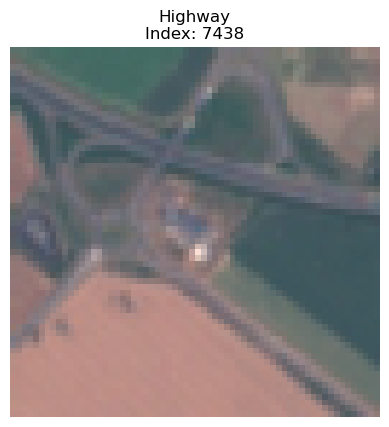

In [7]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(ds))
img, lbl = ds[r]

# Display the image
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(ds.tensor_to_label(lbl) + "\nIndex: " + str(r))
plt.show()

In [8]:
ds.labels[0]

ds[0][0].shape

torch.Size([3, 64, 64])

# Create my custom convolution model for the task

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, nb_classes):
        super(SimpleCNN, self).__init__()
        # inputs (N,3,64,64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lin1  = nn.Linear(32*3*3, 128)
        self.lin2  = nn.Linear(128, nb_classes)
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)

        x = self.relu2(self.conv2(x))
        x = self.pool2(x)

        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool4(x)

        x = self.lin1(x.view(-1, 32*3*3))
        x = self.lin2(x)
        return x

def get_model(nb_classes):
    return SimpleCNN(nb_classes)


In [10]:
# Create a dummy image to test input of the network
dummy_img = torch.zeros(42, 3, 64, 64)
model = get_model(len(ds.classes))
model(dummy_img).shape

torch.Size([42, 32, 3, 3])

### Initialize the model and dataloader

In [117]:
data_loader = DataLoader(ds, batch_size=50, shuffle=True)

train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


num_classes = len(ds.classes)
model = get_model(num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


image = torch.randn(20, 3, 64, 64) # create dummy image
output = model(image)

print(model(image).shape) # show the output of one batch of images

from torchinfo import summary
summary(model) # display summary of the model and number of trainable parameters

Feature batch shape: torch.Size([50, 3, 64, 64])
Labels batch shape: torch.Size([50, 10])
torch.Size([20, 10])


Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Conv2d: 1-1                            1,216
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            6,416
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            4,112
├─ReLU: 1-8                              --
├─Conv2d: 1-9                            8,224
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─Linear: 1-12                           36,992
├─Linear: 1-13                           1,290
Total params: 58,250
Trainable params: 58,250
Non-trainable params: 0

### Send the model to the GPU

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=288, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
)

### Define the training function

In [119]:
def train(dataloader, model, loss_fn, optimizer, device, num_epochs=20):
    train_losses = []
    train_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(dataloader):
            # Move tensors to the configured device
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            # Compute prediction
            pred = model(X)

            # Compute the loss and its gradients
            loss = loss_fn(pred, y.argmax(1))
            loss.backward()

            # Backpropagation step
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y.argmax(1)).sum().item()

            # Display progress
            if batch % 30 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Epoch {epoch+1}, batch {batch+1}/{len(dataloader)}, loss: {loss:.4f}")

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch {epoch+1}, loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%")
    return train_losses, train_accuracies

In [120]:
train_losses, train_accuracies = train(data_loader, model, criterion, optimizer, device, num_epochs=10)

Epoch 1, batch 1/231, loss: 2.3085
Epoch 1, batch 31/231, loss: 2.3098
Epoch 1, batch 61/231, loss: 2.3041
Epoch 1, batch 91/231, loss: 2.2716
Epoch 1, batch 121/231, loss: 2.2865
Epoch 1, batch 151/231, loss: 2.2735
Epoch 1, batch 181/231, loss: 2.2740
Epoch 1, batch 211/231, loss: 2.2760
Epoch 1, loss: 2.2891, accuracy: 15.96%
Epoch 2, batch 1/231, loss: 2.2889
Epoch 2, batch 31/231, loss: 2.2590
Epoch 2, batch 61/231, loss: 2.2609
Epoch 2, batch 91/231, loss: 2.2767
Epoch 2, batch 121/231, loss: 2.2322
Epoch 2, batch 151/231, loss: 2.2710
Epoch 2, batch 181/231, loss: 2.2693
Epoch 2, batch 211/231, loss: 2.2775
Epoch 2, loss: 2.2569, accuracy: 15.96%
Epoch 3, batch 1/231, loss: 2.2073
Epoch 3, batch 31/231, loss: 2.2251
Epoch 3, batch 61/231, loss: 2.2256
Epoch 3, batch 91/231, loss: 2.2303
Epoch 3, batch 121/231, loss: 2.1871
Epoch 3, batch 151/231, loss: 2.1020
Epoch 3, batch 181/231, loss: 2.2548
Epoch 3, batch 211/231, loss: 2.1335
Epoch 3, loss: 2.2065, accuracy: 16.43%
Epoch 4

In [121]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, train_accuracies):
    # Plot loss and accuracy
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(train_losses)
    ax[0].set_title("Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].grid(True)
    ax[1].plot(train_accuracies)
    ax[1].set_title("Training Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(True)
    plt.show()

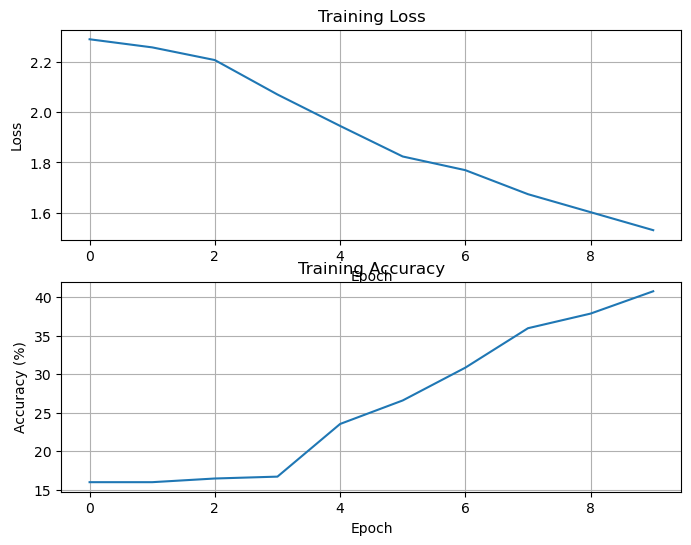

In [122]:
plot_loss_accuracy(train_losses, train_accuracies)

# Coding Challenge <span style="color:red">[à remplir à la fin]</red>
Now that you saw how the data and model could be loaded it is your task to create a model that performs better. For this please fill out the functions in [`CodingChallenge.py`](CodingChallenge.py).  
You may re-use code from this notebook if you wish to and you don't have to re-invent the wheel.

To fully complete the challenge you have to
1. Analyze the data
   * How you do this is up to you and optional codes created in this step don't have to be submitted.
2. Load the data
   * This may include additional steps then just loading
3. Load a model
   * Beware of changes to the model that may apply
   * Your model can be based on an existing architecture (like above) or custom
4. Train the model
   * This may include several steps
5. Evaluate the model
   * The result should be a single score applicable to this task
6. Summarize your findings
   * This may include results of the training process or anything else you want to share

In [12]:
import CodingChallenge as CodingChallenge
# creating model and dataset
my_model = CodingChallenge.get_my_model()
my_ds = CodingChallenge.get_my_ds()

In [13]:
my_model

Ellipsis

In [ ]:
# train the model
my_model = CodingChallenge.train(my_model, my_ds)

In [ ]:
# evaluate the model
the_final_score = CodingChallenge.final_evaluate(my_model, my_ds)

In [ ]:
# summarize the findings
CodingChallenge.summary()